Since we will do the gridsearch on sagemaker. We will use a bigger dataset:
<br>Total observations = 150,000
0 = 75,000: 45,000 from sentiment 140, 30,000 from amazon reviews
<br>1 = 75,000: 30,000 from sentiment 140, 15000 from consumer complaints, 30000 from amazon reviews
<br>All observations from sentiment 140_neutlabels

In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', 0) #To display entire text content of a column
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.metrics import precision_score, recall_score, f1_score
import timeit
import os
import pickle
import joblib as joblib
import re
from functools import reduce
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Anuroop\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
#Change directory 
os.chdir('D:\capstone_data\processed_csv\duplicates_rm')

In [3]:
#Read all dfs
sentiment_140_df = pd.read_csv('sentiment140_no_dplcts_textcol.csv')
sentiment_140_neutlabels =  pd.read_csv('sentiment_140_neutlabels_no_dplcts_textcol.csv')
consumer_complaints_df = pd.read_csv('consumer_complaints_no_dplcts_textcol.csv')
amazonreviews_df = pd.read_csv('amazonreviews_with_label_no_dplcts_textcol.csv')

In [4]:
#Function to extract data points from each df 
def extract_data_pts(df, label, n_pts):
    df = df[df['label'] == label].sample(
    n = n_pts, replace = False, random_state = 7)
    return df

# Extract 0s (Non Greivances)

In [5]:
#Create master_df
master_df = pd.DataFrame()

In [6]:
#45000 from sentiment_140_df
sentiment_140_df_0s_45k = extract_data_pts(sentiment_140_df, 0, 45000)
display(sentiment_140_df_0s_45k['label'].value_counts())
display(sentiment_140_df_0s_45k.tail(1))


0    45000
Name: label, dtype: int64

,text,label
1399913,I gotta find to do somethings..bored,0


In [7]:
#Append to master
master_df = master_df.append(sentiment_140_df_0s_45k, ignore_index = True)

In [8]:
#30000 from amazonreviews_df
amazonreviews_df_0s_30k = extract_data_pts(amazonreviews_df, 0, 30000)
display(amazonreviews_df_0s_30k['label'].value_counts())
display(amazonreviews_df_0s_30k.tail(1))

0    30000
Name: label, dtype: int64

,text,label
324424,"This is a very cool phone, best prepaid phone around IMHO. Screen is very sharp and clear. The phone performs well, most of the time, I have had a few times where it slowed a bit but there are some apps you can install to help with that. Battery life isn't great but its at least as good as most of the other smart phones I have owned. So its what I expected. Over all very satisfied with this phone.",0


In [9]:
#Append to master
master_df = master_df.append(amazonreviews_df_0s_30k, ignore_index = True)
master_df['label'].value_counts()

0    75000
Name: label, dtype: int64

# Extarct 1s Greivances

In [10]:
#30000 from sentiment_140_df
sentiment_140_df_1s_30k = extract_data_pts(sentiment_140_df,1,30000)
display(sentiment_140_df_1s_30k['label'].value_counts())
display(sentiment_140_df_1s_30k.tail(1))

1    30000
Name: label, dtype: int64

,text,label
169283,Somebody buy me a plane ticket home!! I miss my girl...,1


In [11]:
#Append to master
master_df = master_df.append(sentiment_140_df_1s_30k, ignore_index = True)

In [12]:
#15000 from consumer complaints
consumer_complaints_df_1s_15k = extract_data_pts(consumer_complaints_df,1,15000)
display(consumer_complaints_df_1s_15k['label'].value_counts())
display(consumer_complaints_df_1s_15k.tail(1))

1    15000
Name: label, dtype: int64

,text,label
149973,"My husband lost his job in XX/XX/XXXX leaving my income as the only source for paying bills. It has become hard juggling rent, food, creditors and other debts. We contacted Barclay with our situation. With each month we are charged a late fee and over the limit fee. Each time we are told we must pay the minimum passed due amount, which has been difficult on our limited income. With fees mounting our monthly due is skyrocketing and growing out of control. We feel like even when he finds employment we will never be able to catch up and our credit will be ruined.",1


In [13]:
#Append to master
master_df = master_df.append(consumer_complaints_df_1s_15k, ignore_index = True)

In [14]:
#30000 from amazonreviews_df
amazonreviews_df_1s_30k = extract_data_pts(amazonreviews_df,1,30000)
display(amazonreviews_df_1s_30k['label'].value_counts())
display(amazonreviews_df_1s_30k.tail(1))

1    30000
Name: label, dtype: int64

,text,label
629734,It worked well for a week and stopped working after that. Good idea but not very durable. I would not suggest purchasing product.,1


In [15]:
#Append to master
master_df = master_df.append(amazonreviews_df_1s_30k, ignore_index = True)

In [16]:
#Append sentiment_140_neutlabels
master_df = master_df.append(sentiment_140_neutlabels, ignore_index = True)
master_df['label'].value_counts()

0    75321
1    75177
Name: label, dtype: int64

In [17]:
#Verify master df
display(master_df.head(2))
display(master_df.shape)

,text,label
0,@vallywally LOL.. Damm U make commision when SHE wins.. NICEE.. BTW.. What do u play when ure there?,0
1,@k80bug Ohhh I used to make those when I was operations there,0


(150498, 2)

Text column in master_df will be cleaned and saved to a new column 'clean text' using the function created in `data_preprocessing2` that cleans the text for user handles, hashtags etc.

In [18]:
#################################initial Cleaning functions
#contarction map
c_dict = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "cos": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "I would",
    "I'd": "I would",
    "i'd've": "I would have",
    "I'd've": "I would have",
    "i'll": "I will",
    "I'll": "I will",
    "i'll've": "I will have",
    "I'll've": "I will have",
    "i'm": "I am",
    "I'm": "I am",
    "i've": "I have",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'alls": "you alls",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you you will",
    "you'll've": "you you will have",
    "you're": "you are",
    "you've": "you have"
}
#Contraction
c_re = re.compile('(%s)' % '|'.join(c_dict.keys()))


In [19]:
###################################Functions
#Function for expanding contracions
def expand_contractions(sentence, c_re = c_re):
    def replace(match):
        return c_dict[match.group(0)]
    return c_re.sub(replace, sentence)

#Repeated letters func
def trim_repeated_letters(sentence):
    return(reduce(lambda x,y: x+y if x[-2:] != y*2 else x, sentence, ""))

#Compile allsteps above into one function for future use
def text_df_cleaner(df):
    '''
    Cleans 'text' column of a df and creates a new column 'clean_text' with clean text
    '''
    df['clean_text'] = df['text'].apply(lambda x: re.sub("@[\w]*","", x)) #User handles
    df['clean_text'] = df['clean_text'].apply(lambda x: re.sub("#[\w]*","", x)) #hash tags
    df['clean_text'] = df['clean_text'].apply(lambda x: re.sub("http\S+", "", x)) #urls
    df['clean_text'] = df['clean_text'].apply(lambda x: expand_contractions(x)) #expand contractions
    df['clean_text'] = df['clean_text'].apply(lambda x: re.sub("""['!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~']""",
                                                                  " ", x)) #Punctuations
    df['clean_text'] = df['clean_text'].apply(lambda x: re.sub('[^A-Za-z]', ' ', x.lower())) #Numbers and lowercase
    #Repeated letters
    df['clean_text'] = df['clean_text'].apply(lambda x: trim_repeated_letters(x))
    return df

In [20]:
#Apply function to master_df for
text_df_cleaner(master_df)
display(master_df.shape)
display(master_df.tail(10))

(150498, 3)

,text,label,clean_text
150488,@johncmayer is Bobby Flay joining you?,0,is bobby flay joining you
150489,i lam so in love with Bobby Flay... he is my favorite. RT @terrysimpson: @bflay you need a place in Phoenix. We have great peppers here!,0,i lam so in love with bobby flay he is my favorite rt you need a place in phoenix we have great peppers here
150490,"I just created my first LaTeX file from scratch. That didn't work out very well. (See @amandabittner , it's a great time waster)",1,i just created my first latex file from scratch that did not work out very well see it is a great time waster
150491,using Linux and loving it - so much nicer than windows... Looking forward to using the wysiwyg latex editor!,0,using linux and loving it so much nicer than windows looking forward to using the wysiwyg latex editor
150492,"After using LaTeX a lot, any other typeset mathematics just looks hideous.",0,after using latex a lot any other typeset mathematics just looks hideous
150493,Ask Programming: LaTeX or InDesign?: submitted by calcio1 [link] [1 comment] http://tinyurl.com/myfmf7,0,ask programming latex or indesign submitted by calcio link comment
150494,"On that note, I hate Word. I hate Pages. I hate LaTeX. There, I said it. I hate LaTeX. All you TEXN3RDS can come kill me now.",1,on that note i hate word i hate pages i hate latex there i said it i hate latex all you texn rds can come kill me now
150495,Ahhh... back in a *real* text editing environment. I &lt;3 LaTeX.,0,ahh back in a real text editing environment i lt latex
150496,"Trouble in Iran, I see. Hmm. Iran. Iran so far away. #flockofseagullsweregeopoliticallycorrect",1,trouble in iran i see hmm iran iran so far away
150497,Reading the tweets coming out of Iran... The whole thing is terrifying and incredibly sad...,1,reading the tweets coming out of iran the whole thing is terrifying and incredibly sad


In [21]:
#Dropping 'text' column
master_df.drop(columns = ['text'], inplace = True)
master_df.tail()

,label,clean_text
150493,0,ask programming latex or indesign submitted by calcio link comment
150494,1,on that note i hate word i hate pages i hate latex there i said it i hate latex all you texn rds can come kill me now
150495,0,ahh back in a real text editing environment i lt latex
150496,1,trouble in iran i see hmm iran iran so far away
150497,1,reading the tweets coming out of iran the whole thing is terrifying and incredibly sad


In [22]:
#Write master_df to csv
master_df.to_csv('D:\capstone_data\processed_csv\master_data_clean_sent140_cmplnts_mixed\master_df_150k_clean.csv', 
                 index = False)

# Prototype hyperparameter tuning code for sagemaker

Vectorizer will have to be refit because we'll be working with a bigger dataset than that for intial fits.

In [2]:
os.chdir('D:\capstone_data\processed_csv\master_data_clean_sent140_cmplnts_mixed')

In [4]:
#Read master data
tweet_complaints_df_150 = pd.read_csv('master_df_150k_clean.csv')
display(tweet_complaints_df_150.shape)
display(tweet_complaints_df_150.tail())

(150498, 2)

,label,clean_text
150493,0,ask programming latex or indesign submitted by calcio link comment
150494,1,on that note i hate word i hate pages i hate latex there i said it i hate latex all you texn rds can come kill me now
150495,0,ahh back in a real text editing environment i lt latex
150496,1,trouble in iran i see hmm iran iran so far away
150497,1,reading the tweets coming out of iran the whole thing is terrifying and incredibly sad


In [5]:
#Feature and target
X = tweet_complaints_df_150['clean_text']
display(X.head(1))
y = tweet_complaints_df_150['label']
display(y.head(1))

0     lol  damm u make commision when she wins  nicee  btw  what do u play when ure there 
Name: clean_text, dtype: object

0    0
Name: label, dtype: int64

In [6]:
#train test split before vectorization to avoid information being carried over to test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    random_state = 7)

In [7]:
#Verify
display(X_train.shape)
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(120398,)

(30100,)

(120398,)

(30100,)

## Bagofwords fit

In [9]:
################################import filter list and custom tokenizer from vectorization_fit_model
#Filter list to remove product names
filter_ls = ['debt',
 'collection',
 'collections',
 'mortgage',
 'credit',
 'report',
 'reports',
 'bank',
 'loan',
 'xx']

In [10]:
#Create a stemmer object and define stop words
stemmer = nltk.PorterStemmer()
ENGLISH_STOP_WORDS = stopwords.words('english')

In [11]:
#Custom tokenizer
def cust_tokenizer_prods_rmvd(sentence):
   # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        #Include filter_ls
        if (not word in ENGLISH_STOP_WORDS) and (not word in filter_ls) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

In [14]:
#Instantiate using cust_tokenizer_prods_rmvd and only words that appear in atleast 1% of documents
bagofwords = CountVectorizer(tokenizer = cust_tokenizer_prods_rmvd, min_df = 0.01,
                            ngram_range =(1,3))

#Fit vectorizer on X_train 
bagofwords.fit(X_train)


#Transform
X_train_transformed = bagofwords.transform(X_train)
X_test_transformed = bagofwords.transform(X_test)

#Check number of features in train and test
display(X_train_transformed.shape)
display(X_test_transformed.shape)

C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


(120398, 654)

(30100, 654)

In [32]:
######Save vectorizer
joblib.dump(bagofwords, 'bagofwords_rm_prdcts_150K.pkl')

['bagofwords_rm_prdcts_150K.pkl']

In [15]:
#Create a df of transformed data
X_train_transformed_df = pd.DataFrame(columns = bagofwords.get_feature_names(),
                                     data = X_train_transformed.toarray())
display(X_train_transformed_df.head(1))

X_test_transformed_df = pd.DataFrame(columns = bagofwords.get_feature_names(),
                                     data = X_test_transformed.toarray())
display(X_test_transformed_df.head(1))


,abl,absolut,accept,access,account,action,activ,actual,ad,add,...,would recommend,write,wrong,x,ye,year,year ago,year old,yet,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,abl,absolut,accept,access,account,action,activ,actual,ad,add,...,would recommend,write,wrong,x,ye,year,year ago,year old,yet,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
#Top 20 most frequent words
top_20_words = X_train_transformed_df.sum(axis = 0).sort_values(ascending = False)[:19]

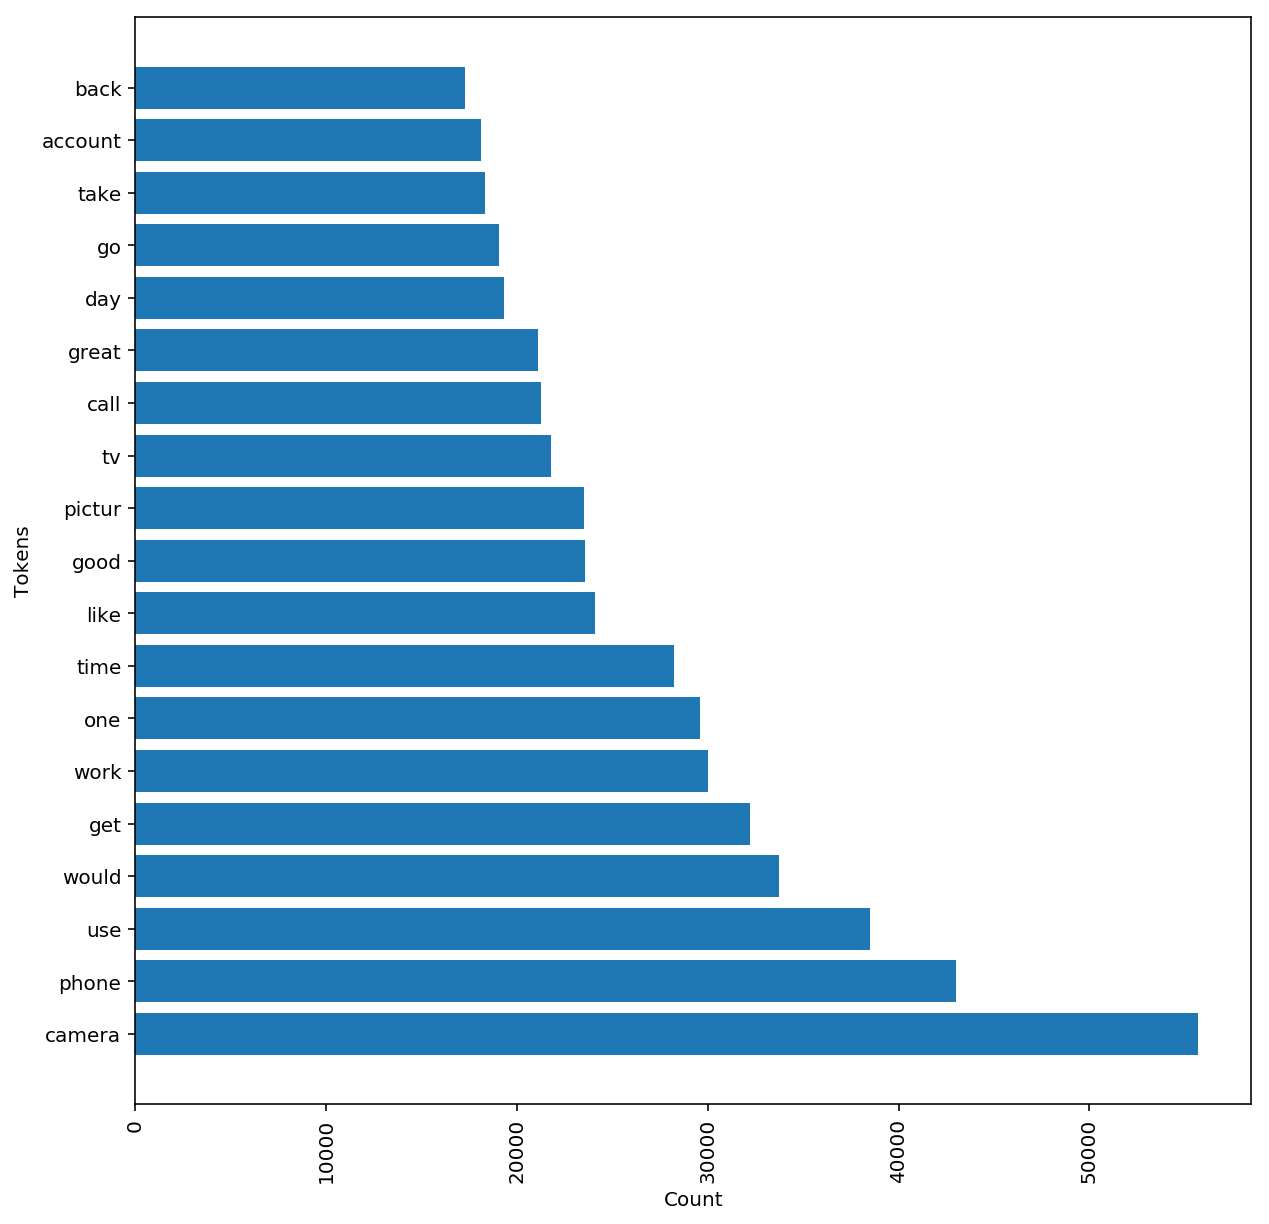

In [35]:
#Visualize vectorized data
plt.figure(figsize =(10,10))
plt.barh(top_20_words.index, top_20_words.values)
plt.xlabel("Count")
plt.xticks(rotation = 90)
#plt.xlim(100,35000)
plt.ylabel("Tokens")
plt.show()

# Baseline Log Reg and Random forest

In [16]:
# Fit a logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train_transformed_df, y_train)
#Accuracy
print(f"The accuracy of unoptimized Log reg model on train set is: {round(log_reg.score(X_train_transformed_df,y_train),2)}")
print(f"The accuracy of unoptimized Log reg model on train set is: {round(log_reg.score(X_test_transformed_df,y_test),2)}")

C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


The accuracy of unoptimized Log reg model on train set is: 0.79
The accuracy of unoptimized Log reg model on train set is: 0.78


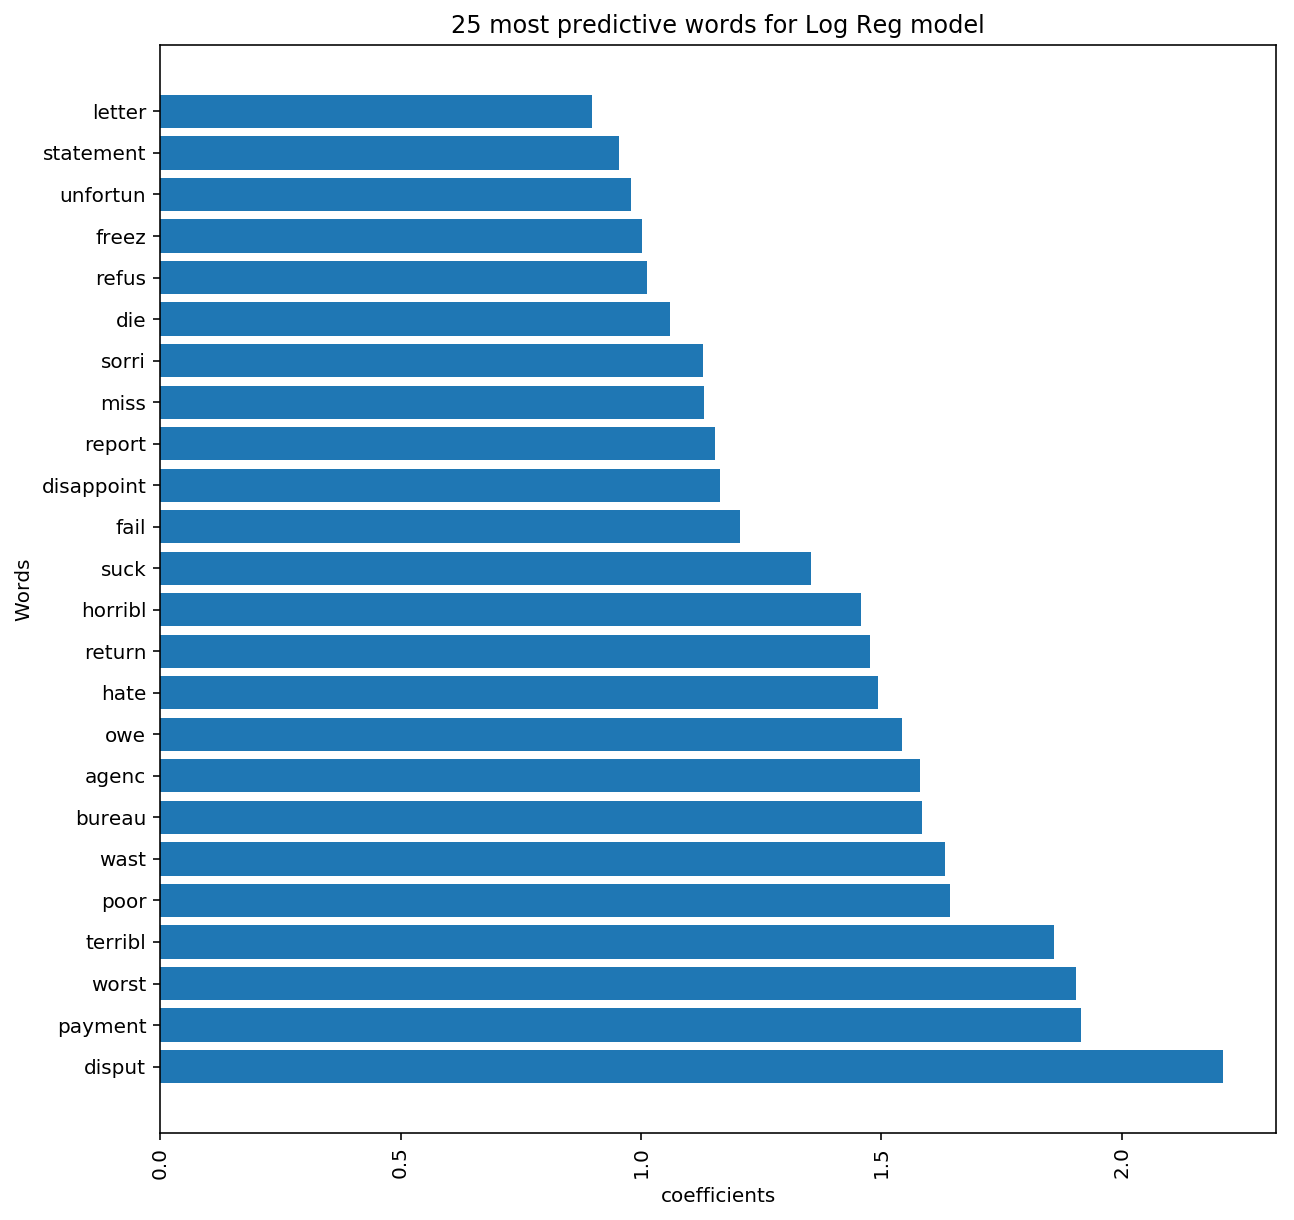

In [17]:
#Create a df for feature coefficients
coef_df = pd.DataFrame(data = log_reg.coef_, columns = X_train_transformed_df.columns, 
                       index = ['coef'])

#Top 25 words 
coef_df_top_25 = coef_df.sort_values(by ='coef', axis = 1, ascending = False).iloc[:,:24]

#Visualize top 25 words
plt.figure(figsize =(10,10))
plt.barh(coef_df_top_25.loc['coef'].index, coef_df_top_25.loc['coef'].values)
plt.xlabel("coefficients")
plt.xticks(rotation = 90)
plt.ylabel("Words")
plt.title('25 most predictive words for Log Reg model')
plt.show()

In [18]:
#Fit random forest
rand_forest = RandomForestClassifier()
rand_forest.fit(X_train_transformed_df, y_train)
#Verify accuracy
print(f"The accuracy of unoptimized random forest on train set is: {round(rand_forest.score(X_train_transformed_df,y_train),2)}")
print(f"The accuracy of unoptimized random forest on test set is: {round(rand_forest.score(X_test_transformed_df,y_test),2)}")

The accuracy of unoptimized random forest on train set is: 0.96
The accuracy of unoptimized random forest on test set is: 0.78


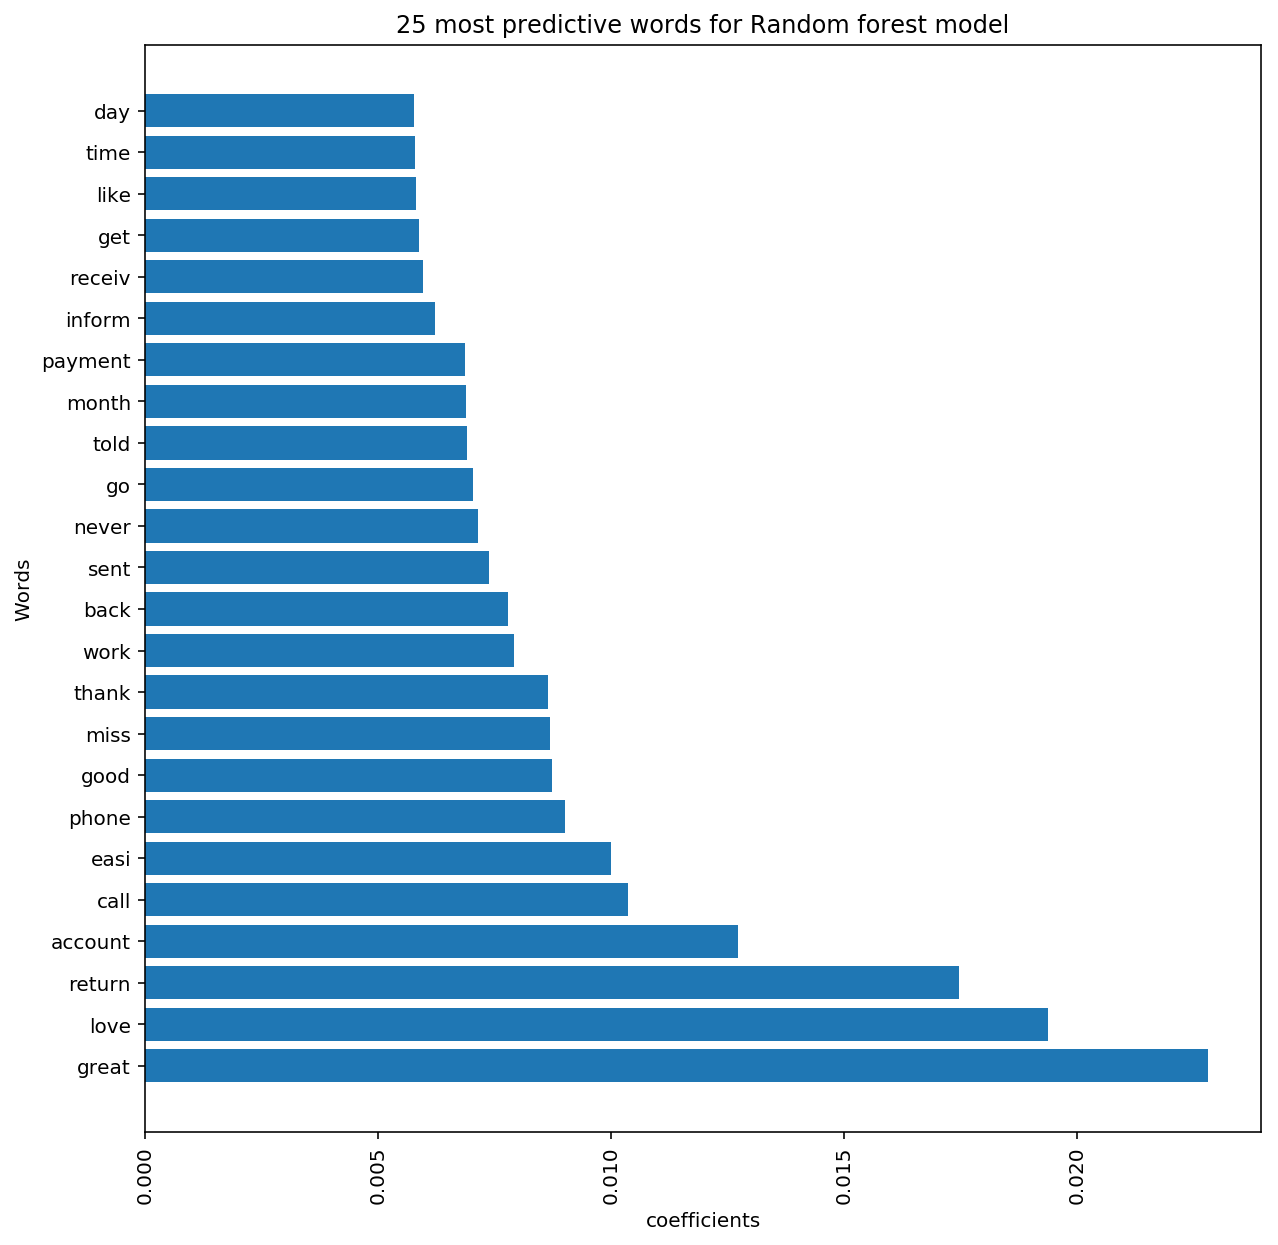

In [19]:
#Create a df for feature coefficients
coef_df = pd.DataFrame(data = rand_forest.feature_importances_.reshape(1, len(X_train_transformed_df.columns)), 
                       columns = X_train_transformed_df.columns,
                       index = ['coef'])

#Top 25 words 
coef_df_top_25 = coef_df.sort_values(by ='coef', axis = 1, ascending = False).iloc[:,:24]

#Visualize top 25 words
plt.figure(figsize =(10,10))
plt.barh(coef_df_top_25.loc['coef'].index, coef_df_top_25.loc['coef'].values)
plt.xlabel("coefficients")
plt.xticks(rotation = 90)
plt.ylabel("Words")
plt.title('25 most predictive words for Random forest model')
plt.show()

Most important predictor is a positive word `great`. It must be noted that, for random forest, predictor with highest coefficient is not the one that contributes most towards classification of positive class but rather what helps discern between the two classes i.e help split between the two. So positive words being the top predictors do make sense in this context. There are certain words like 'phone', 'call' that do not make sense but this an unopotimized model, we will tune parameters and verify results gaian. 

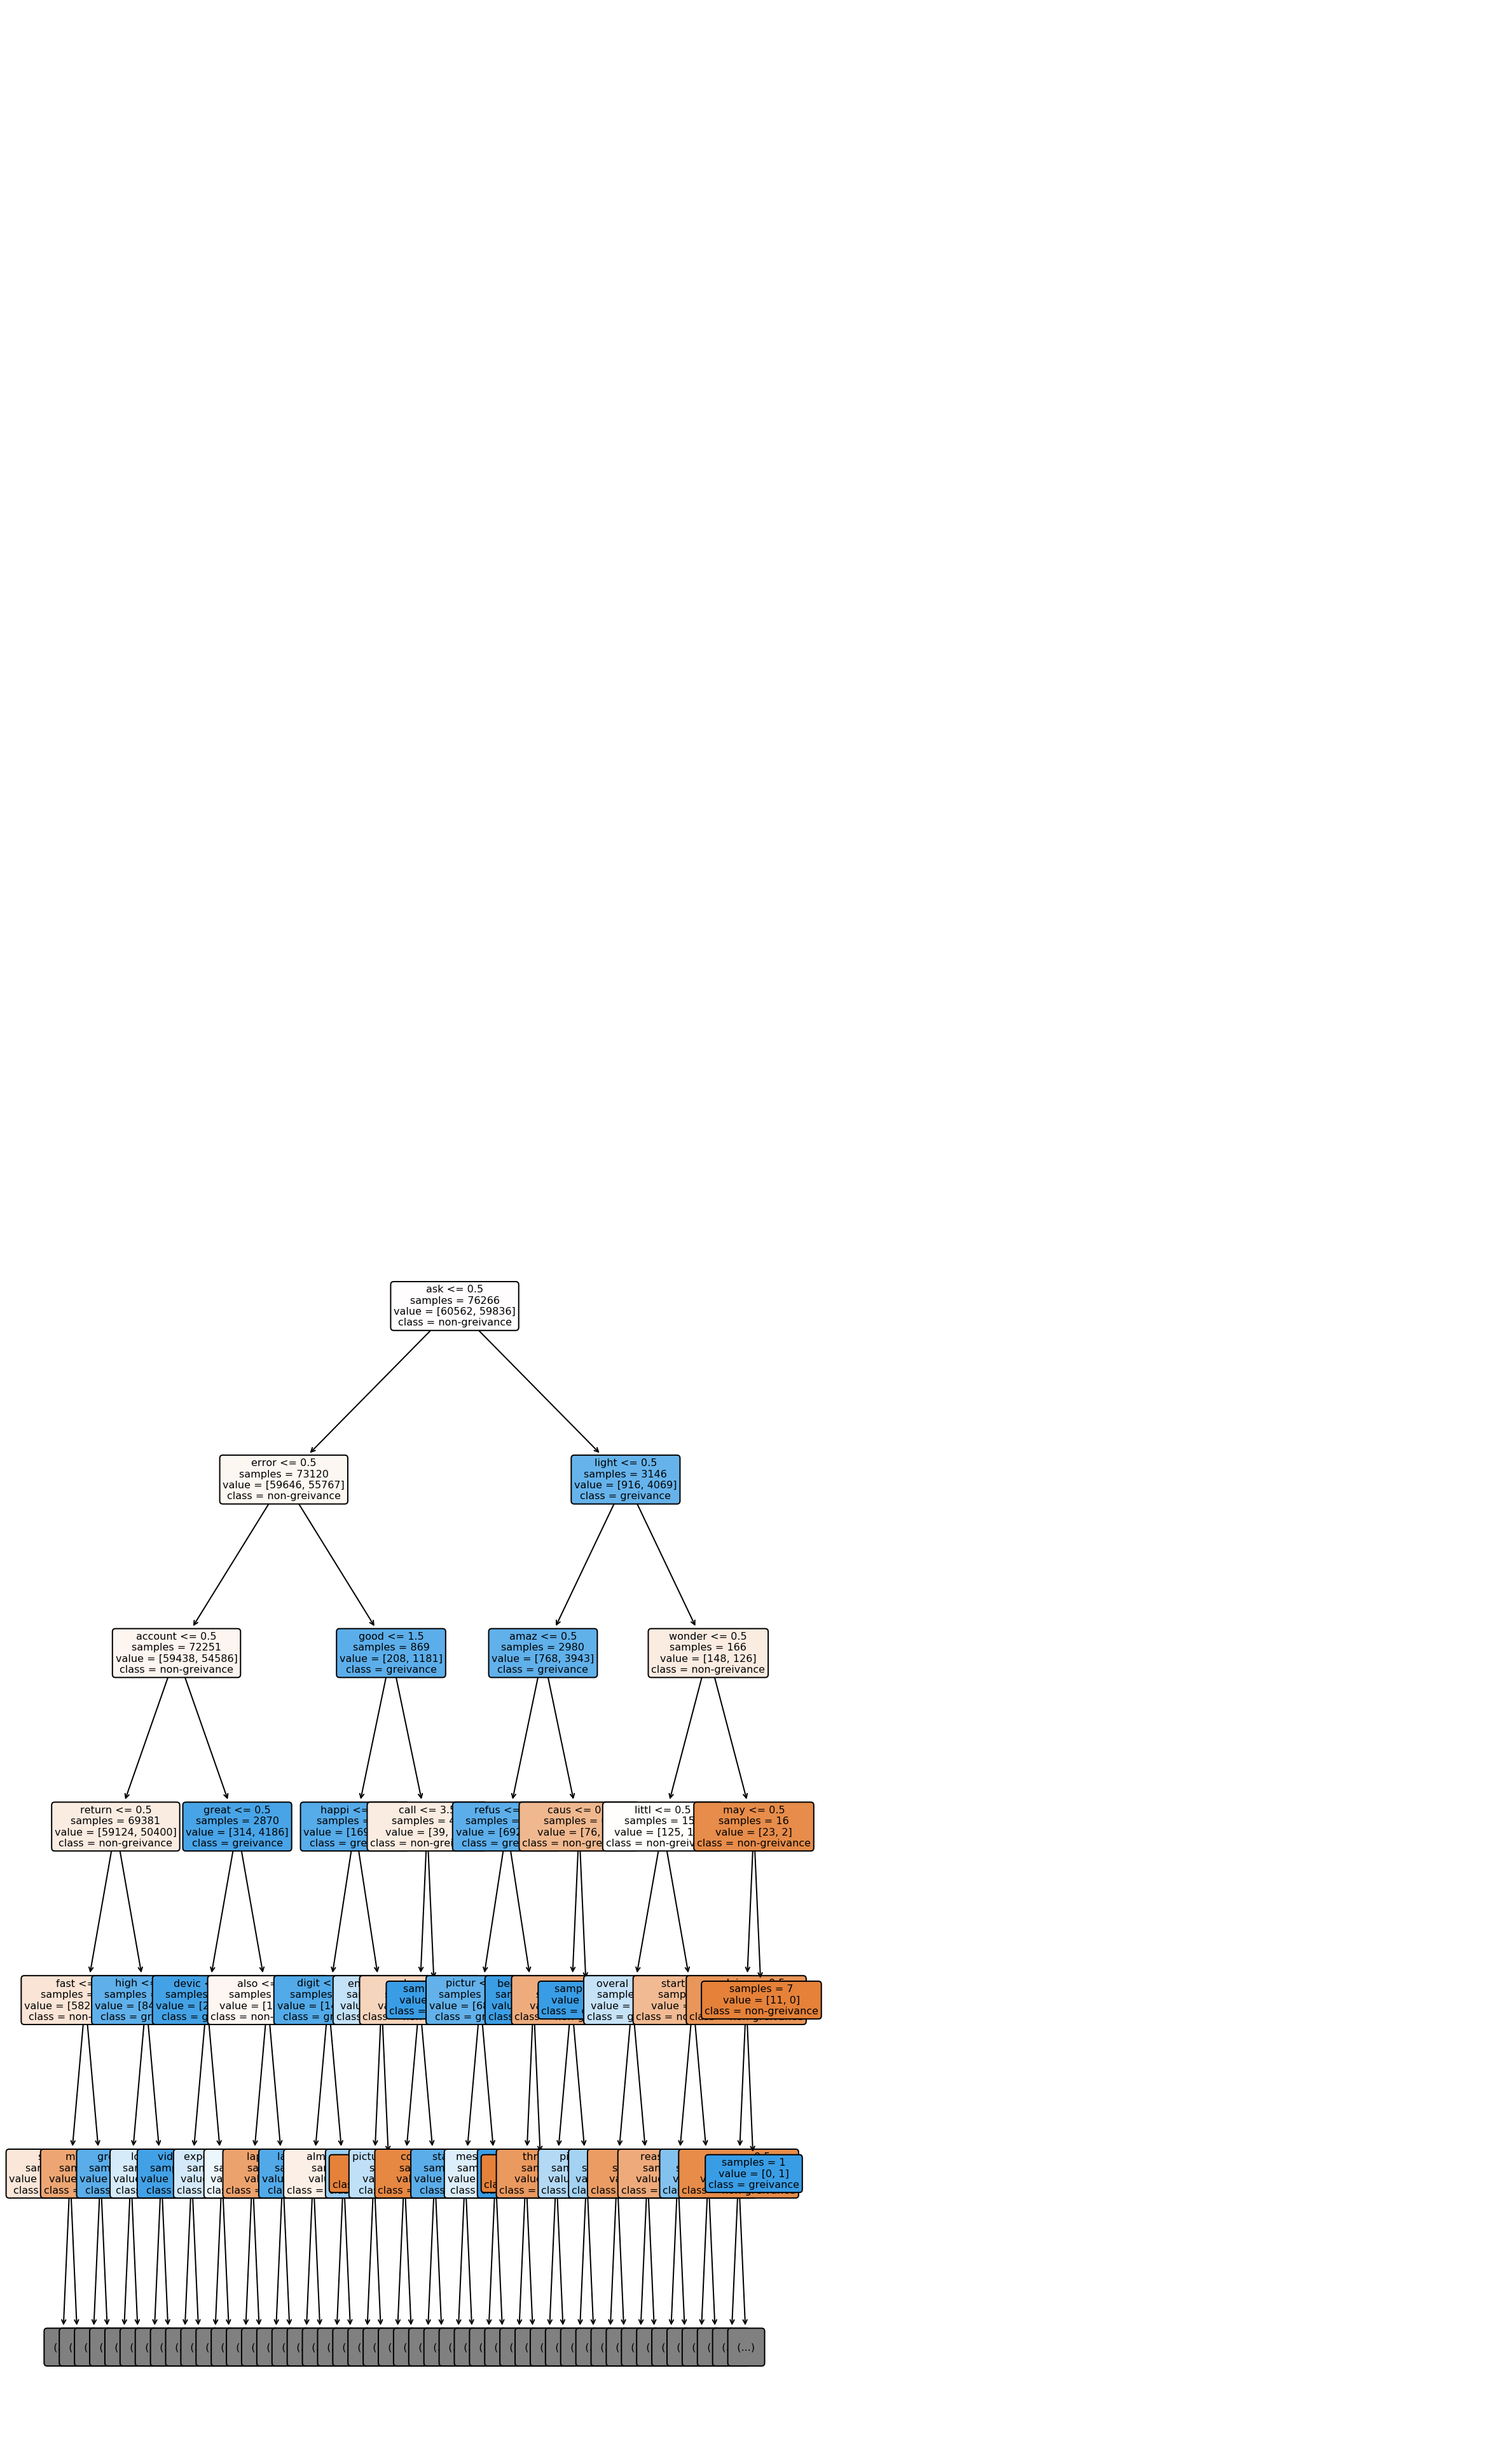

Tree Depth: 607

Number of leaves: 31242


In [25]:
#Visualize 1 tree 
plt.figure(figsize = (20, 35))
plot_tree(rand_forest.estimators_[1], 
          feature_names = X_train_transformed_df.columns, 
          class_names=['non-greivance', 'greivance'],
          rounded=True,
          impurity=False,
          filled=True,
         max_depth = 5,
         fontsize=  8);
plt.show()
print (f"Tree Depth: {rand_forest.estimators_[1].get_depth()}\n")
print (f"Number of leaves: {rand_forest.estimators_[1].get_n_leaves()}")

In [24]:
#Get current params
rand_forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## Prototype code for sagemaker

In the next few steps, we will prototype the steps needed to optimized Logistic Regression, SVM and decision tree on sagemaker. We will start with saving vectorized train and test to be uploaded on s3.

In [3]:
#Save transformed train and test dataset to be uploaded in s3
X_train_transformed_df.to_csv('X_train_clean_transformed.csv', index = False)
y_train.to_csv('y_train.csv', index = False)
X_test_transformed_df.to_csv('X_test_clean_transformed.csv', index = False)
y_test.to_csv('y_test.csv', index = False)

NameError: name 'X_train_transformed_df' is not defined

In [3]:
#Read
X_train_transformed_df = pd.read_csv('X_train_clean_transformed.csv')

y_train_col_vector = pd.read_csv('y_train.csv', header = None)
#Convert y_train to a series as it is read as a column vector from csv
y_train = y_train_col_vector[0]

In [4]:
#Verify
display(X_train_transformed_df.shape)
display(y_train.shape)

(120398, 654)

(120398,)

In [5]:
#Extract a small sample of 100 data points from train data to write a working code for sagemaker
X_train_transformed_df_sm_sample = X_train_transformed_df.sample(n = 100, replace = False, random_state = 7)
display(X_train_transformed_df_sm_sample.shape)
display(X_train_transformed_df_sm_sample.head())


(100, 654)

,abl,absolut,accept,access,account,action,activ,actual,ad,add,...,would recommend,write,wrong,x,ye,year,year ago,year old,yet,zoom
98030,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101022,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19684,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
26246,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59571,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
#y_train sample of length 100
y_train_sm_sample = y_train[:100]
len(y_train_sm_sample)

100

## Param Grid design for log reg


Chart from https://scikit-learn.org/stable/modules/linear_model.html

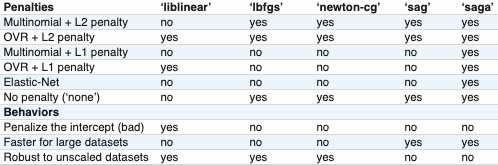

To design the parameter grid for Logistic regression we will refer to the chart above to understand which penalty is applicable on a solver and their behavior. Since we have just have two classes, our problem is OVR i.e. one vs rest and not multinomial (multi class).
<br>`liblinear`: Allows for both L1 and L2 penalty on OVR. It's also the only model thata penalizes the intercept which may not necessarily be goood for the model but it's worth analyzing. **We will use liblinear solver with both L1 and L2 penalties.**<br><br>`lbfgs`: lbfgs allows for L2 penalty and no penalty. **We will use lbfgs with No penalty and L2 penalty**.<br><br>`newton-cg`: nothing really stands out withe newton-cg. Penalty criterion and behavior is very similar to that of `lbfgs` and **hence will be ignored.**<br><br>`saga` is an extension of `sag`. It has features like being faster for large datasets and allows for Elastic net penalty as well. Hence we can ignore `sag` and focus on`saga`. Elasticnet is an interesting penalty that allows for a linear combination of both L1 and L2. Specified `l1 ratio` decides the proportions in which L1 and L2 will be combined. `l1 ratio` of 0 means penalty is L2 and 1 means it is L1. **We will try `elasticnet` penalty `l1_ratio` between 0.2 and 0.8, in steps of 0.1, to account for scenarios leaning towards each penalty and also a balanced scenario at 0.5.**

In [38]:
#Logistic Regression grid search
estimators = [('model', LogisticRegression(max_iter = 300))]

pipe = Pipeline(estimators)

param_grid = [
    {#l1
        'model__penalty':['l1'],
        'model__solver' :['liblinear'],
        'model__C': np.logspace(-3,3,7)
    },
    {#l2
        'model__penalty':['l2'],
        'model__solver' :['liblinear','lbfgs','saga'],
        'model__C': np.logspace(-3,3,7)
        
    },
    {#elasticnet
        'model__penalty':['elasticnet'],
        'model__l1_ratio':np.arange(0.2,0.8,0.1),
        'model__solver' :['saga'],
        'model__C': np.logspace(-3,3,7)
    },
    {#No penalty
        'model__penalty':['none'],
        'model__solver' :['lbfgs']}
]

log_reg_grid_recall = GridSearchCV(
estimator = pipe,
param_grid = param_grid,
cv = 3,
verbose = 5,
#n_jobs = -1,
scoring = 'recall')

log_reg_grid_recall.fit(X_train_transformed_df_sm_sample, y_train_sm_sample)

Fitting 3 folds for each of 78 candidates, totalling 234 fits
[CV 1/3] END model__C=0.001, model__penalty=l1, model__random_state=1, model__solver=liblinear; total time=   0.0s
[CV 2/3] END model__C=0.001, model__penalty=l1, model__random_state=1, model__solver=liblinear; total time=   0.0s
[CV 3/3] END model__C=0.001, model__penalty=l1, model__random_state=1, model__solver=liblinear; total time=   0.0s
[CV 1/3] END model__C=0.01, model__penalty=l1, model__random_state=1, model__solver=liblinear; total time=   0.0s
[CV 2/3] END model__C=0.01, model__penalty=l1, model__random_state=1, model__solver=liblinear; total time=   0.0s
[CV 3/3] END model__C=0.01, model__penalty=l1, model__random_state=1, model__solver=liblinear; total time=   0.0s
[CV 1/3] END model__C=0.1, model__penalty=l1, model__random_state=1, model__solver=liblinear; total time=   0.0s
[CV 2/3] END model__C=0.1, model__penalty=l1, model__random_state=1, model__solver=liblinear; total time=   0.0s
[CV 3/3] END model__C=0.1

C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 1/3] END model__C=0.1, model__penalty=l2, model__random_state=1, model__solver=saga; total time=   0.1s
[CV 2/3] END model__C=0.1, model__penalty=l2, model__random_state=1, model__solver=saga; total time=   0.1s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 3/3] END model__C=0.1, model__penalty=l2, model__random_state=1, model__solver=saga; total time=   0.1s
[CV 1/3] END model__C=1.0, model__penalty=l2, model__random_state=1, model__solver=liblinear; total time=   0.0s
[CV 2/3] END model__C=1.0, model__penalty=l2, model__random_state=1, model__solver=liblinear; total time=   0.0s
[CV 3/3] END model__C=1.0, model__penalty=l2, model__random_state=1, model__solver=liblinear; total time=   0.0s
[CV 1/3] END model__C=1.0, model__penalty=l2, model__random_state=1, model__solver=lbfgs; total time=   0.0s
[CV 2/3] END model__C=1.0, model__penalty=l2, model__random_state=1, model__solver=lbfgs; total time=   0.0s
[CV 3/3] END model__C=1.0, model__penalty=l2, model__random_state=1, model__solver=lbfgs; total time=   0.0s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 1/3] END model__C=1.0, model__penalty=l2, model__random_state=1, model__solver=saga; total time=   0.1s
[CV 2/3] END model__C=1.0, model__penalty=l2, model__random_state=1, model__solver=saga; total time=   0.0s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 3/3] END model__C=1.0, model__penalty=l2, model__random_state=1, model__solver=saga; total time=   0.0s
[CV 1/3] END model__C=10.0, model__penalty=l2, model__random_state=1, model__solver=liblinear; total time=   0.0s
[CV 2/3] END model__C=10.0, model__penalty=l2, model__random_state=1, model__solver=liblinear; total time=   0.0s
[CV 3/3] END model__C=10.0, model__penalty=l2, model__random_state=1, model__solver=liblinear; total time=   0.0s
[CV 1/3] END model__C=10.0, model__penalty=l2, model__random_state=1, model__solver=lbfgs; total time=   0.0s
[CV 2/3] END model__C=10.0, model__penalty=l2, model__random_state=1, model__solver=lbfgs; total time=   0.0s
[CV 3/3] END model__C=10.0, model__penalty=l2, model__random_state=1, model__solver=lbfgs; total time=   0.0s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 1/3] END model__C=10.0, model__penalty=l2, model__random_state=1, model__solver=saga; total time=   0.0s
[CV 2/3] END model__C=10.0, model__penalty=l2, model__random_state=1, model__solver=saga; total time=   0.1s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 3/3] END model__C=10.0, model__penalty=l2, model__random_state=1, model__solver=saga; total time=   0.0s
[CV 1/3] END model__C=100.0, model__penalty=l2, model__random_state=1, model__solver=liblinear; total time=   0.0s
[CV 2/3] END model__C=100.0, model__penalty=l2, model__random_state=1, model__solver=liblinear; total time=   0.0s
[CV 3/3] END model__C=100.0, model__penalty=l2, model__random_state=1, model__solver=liblinear; total time=   0.0s
[CV 1/3] END model__C=100.0, model__penalty=l2, model__random_state=1, model__solver=lbfgs; total time=   0.0s
[CV 2/3] END model__C=100.0, model__penalty=l2, model__random_state=1, model__solver=lbfgs; total time=   0.0s
[CV 3/3] END model__C=100.0, model__penalty=l2, model__random_state=1, model__solver=lbfgs; total time=   0.0s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 1/3] END model__C=100.0, model__penalty=l2, model__random_state=1, model__solver=saga; total time=   0.0s
[CV 2/3] END model__C=100.0, model__penalty=l2, model__random_state=1, model__solver=saga; total time=   0.1s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 3/3] END model__C=100.0, model__penalty=l2, model__random_state=1, model__solver=saga; total time=   0.0s
[CV 1/3] END model__C=1000.0, model__penalty=l2, model__random_state=1, model__solver=liblinear; total time=   0.0s
[CV 2/3] END model__C=1000.0, model__penalty=l2, model__random_state=1, model__solver=liblinear; total time=   0.0s
[CV 3/3] END model__C=1000.0, model__penalty=l2, model__random_state=1, model__solver=liblinear; total time=   0.0s
[CV 1/3] END model__C=1000.0, model__penalty=l2, model__random_state=1, model__solver=lbfgs; total time=   0.0s
[CV 2/3] END model__C=1000.0, model__penalty=l2, model__random_state=1, model__solver=lbfgs; total time=   0.0s
[CV 3/3] END model__C=1000.0, model__penalty=l2, model__random_state=1, model__solver=lbfgs; total time=   0.0s
[CV 1/3] END model__C=1000.0, model__penalty=l2, model__random_state=1, model__solver=saga; total time=   0.0s
[CV 2/3] END model__C=1000.0, model__penalty=l2, model__random_state=1, model__solver=saga; tot

C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 3/3] END model__C=1000.0, model__penalty=l2, model__random_state=1, model__solver=saga; total time=   0.0s
[CV 1/3] END model__C=0.001, model__l1_ratio=0.2, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.0s
[CV 2/3] END model__C=0.001, model__l1_ratio=0.2, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.0s
[CV 3/3] END model__C=0.001, model__l1_ratio=0.2, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.0s
[CV 1/3] END model__C=0.001, model__l1_ratio=0.30000000000000004, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.0s
[CV 2/3] END model__C=0.001, model__l1_ratio=0.30000000000000004, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.0s
[CV 3/3] END model__C=0.001, model__l1_ratio=0.30000000000000004, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.0s
[CV 1/3

C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 2/3] END model__C=0.1, model__l1_ratio=0.2, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.0s
[CV 3/3] END model__C=0.1, model__l1_ratio=0.2, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.0s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 1/3] END model__C=0.1, model__l1_ratio=0.30000000000000004, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.0s
[CV 2/3] END model__C=0.1, model__l1_ratio=0.30000000000000004, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.0s
[CV 3/3] END model__C=0.1, model__l1_ratio=0.30000000000000004, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.0s
[CV 1/3] END model__C=0.1, model__l1_ratio=0.4000000000000001, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.0s
[CV 2/3] END model__C=0.1, model__l1_ratio=0.4000000000000001, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.0s
[CV 3/3] END model__C=0.1, model__l1_ratio=0.4000000000000001, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.0s
[CV 1/3] END model__C=0.1, model__l1_ratio=0.5000000000000001, model__penalty=elastic

C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 3/3] END model__C=0.1, model__l1_ratio=0.6000000000000001, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.0s
[CV 1/3] END model__C=0.1, model__l1_ratio=0.7000000000000002, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.0s
[CV 2/3] END model__C=0.1, model__l1_ratio=0.7000000000000002, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.0s
[CV 3/3] END model__C=0.1, model__l1_ratio=0.7000000000000002, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.0s
[CV 1/3] END model__C=0.1, model__l1_ratio=0.8000000000000003, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.0s
[CV 2/3] END model__C=0.1, model__l1_ratio=0.8000000000000003, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.0s
[CV 3/3] END model__C=0.1, model__l1_ratio=0.8000000000000003, model__penalty=elasticnet

C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 2/3] END model__C=1.0, model__l1_ratio=0.2, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.0s
[CV 3/3] END model__C=1.0, model__l1_ratio=0.2, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.0s
[CV 1/3] END model__C=1.0, model__l1_ratio=0.30000000000000004, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.0s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 2/3] END model__C=1.0, model__l1_ratio=0.30000000000000004, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.0s
[CV 3/3] END model__C=1.0, model__l1_ratio=0.30000000000000004, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.0s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 1/3] END model__C=1.0, model__l1_ratio=0.4000000000000001, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.0s
[CV 2/3] END model__C=1.0, model__l1_ratio=0.4000000000000001, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.0s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 3/3] END model__C=1.0, model__l1_ratio=0.4000000000000001, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.0s
[CV 1/3] END model__C=1.0, model__l1_ratio=0.5000000000000001, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.0s
[CV 2/3] END model__C=1.0, model__l1_ratio=0.5000000000000001, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.0s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 3/3] END model__C=1.0, model__l1_ratio=0.5000000000000001, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.0s
[CV 1/3] END model__C=1.0, model__l1_ratio=0.6000000000000001, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.0s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 2/3] END model__C=1.0, model__l1_ratio=0.6000000000000001, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.0s
[CV 3/3] END model__C=1.0, model__l1_ratio=0.6000000000000001, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.0s
[CV 1/3] END model__C=1.0, model__l1_ratio=0.7000000000000002, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.0s
[CV 2/3] END model__C=1.0, model__l1_ratio=0.7000000000000002, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.0s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 3/3] END model__C=1.0, model__l1_ratio=0.7000000000000002, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.0s
[CV 1/3] END model__C=1.0, model__l1_ratio=0.8000000000000003, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.0s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 2/3] END model__C=1.0, model__l1_ratio=0.8000000000000003, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.0s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 3/3] END model__C=1.0, model__l1_ratio=0.8000000000000003, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.1s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 1/3] END model__C=10.0, model__l1_ratio=0.2, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.3s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 2/3] END model__C=10.0, model__l1_ratio=0.2, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.2s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 3/3] END model__C=10.0, model__l1_ratio=0.2, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.2s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 1/3] END model__C=10.0, model__l1_ratio=0.30000000000000004, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.2s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 2/3] END model__C=10.0, model__l1_ratio=0.30000000000000004, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.2s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 3/3] END model__C=10.0, model__l1_ratio=0.30000000000000004, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.2s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 1/3] END model__C=10.0, model__l1_ratio=0.4000000000000001, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.3s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 2/3] END model__C=10.0, model__l1_ratio=0.4000000000000001, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.3s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 3/3] END model__C=10.0, model__l1_ratio=0.4000000000000001, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.3s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 1/3] END model__C=10.0, model__l1_ratio=0.5000000000000001, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.3s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 2/3] END model__C=10.0, model__l1_ratio=0.5000000000000001, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.3s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 3/3] END model__C=10.0, model__l1_ratio=0.5000000000000001, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.3s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 1/3] END model__C=10.0, model__l1_ratio=0.6000000000000001, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.3s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 2/3] END model__C=10.0, model__l1_ratio=0.6000000000000001, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.2s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 3/3] END model__C=10.0, model__l1_ratio=0.6000000000000001, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.2s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 1/3] END model__C=10.0, model__l1_ratio=0.7000000000000002, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.2s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 2/3] END model__C=10.0, model__l1_ratio=0.7000000000000002, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.2s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 3/3] END model__C=10.0, model__l1_ratio=0.7000000000000002, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.2s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 1/3] END model__C=10.0, model__l1_ratio=0.8000000000000003, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.2s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 2/3] END model__C=10.0, model__l1_ratio=0.8000000000000003, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.2s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 3/3] END model__C=10.0, model__l1_ratio=0.8000000000000003, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.2s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 1/3] END model__C=100.0, model__l1_ratio=0.2, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.2s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 2/3] END model__C=100.0, model__l1_ratio=0.2, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.3s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 3/3] END model__C=100.0, model__l1_ratio=0.2, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.3s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 1/3] END model__C=100.0, model__l1_ratio=0.30000000000000004, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.2s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 2/3] END model__C=100.0, model__l1_ratio=0.30000000000000004, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.2s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 3/3] END model__C=100.0, model__l1_ratio=0.30000000000000004, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.2s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 1/3] END model__C=100.0, model__l1_ratio=0.4000000000000001, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.2s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 2/3] END model__C=100.0, model__l1_ratio=0.4000000000000001, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.2s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 3/3] END model__C=100.0, model__l1_ratio=0.4000000000000001, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.3s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 1/3] END model__C=100.0, model__l1_ratio=0.5000000000000001, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.3s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 2/3] END model__C=100.0, model__l1_ratio=0.5000000000000001, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.2s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 3/3] END model__C=100.0, model__l1_ratio=0.5000000000000001, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.2s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 1/3] END model__C=100.0, model__l1_ratio=0.6000000000000001, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.3s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 2/3] END model__C=100.0, model__l1_ratio=0.6000000000000001, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.3s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 3/3] END model__C=100.0, model__l1_ratio=0.6000000000000001, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.3s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 1/3] END model__C=100.0, model__l1_ratio=0.7000000000000002, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.1s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 2/3] END model__C=100.0, model__l1_ratio=0.7000000000000002, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.2s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 3/3] END model__C=100.0, model__l1_ratio=0.7000000000000002, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.2s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 1/3] END model__C=100.0, model__l1_ratio=0.8000000000000003, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.2s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 2/3] END model__C=100.0, model__l1_ratio=0.8000000000000003, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.2s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 3/3] END model__C=100.0, model__l1_ratio=0.8000000000000003, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.3s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 1/3] END model__C=1000.0, model__l1_ratio=0.2, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.3s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 2/3] END model__C=1000.0, model__l1_ratio=0.2, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.3s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 3/3] END model__C=1000.0, model__l1_ratio=0.2, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.2s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 1/3] END model__C=1000.0, model__l1_ratio=0.30000000000000004, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.2s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 2/3] END model__C=1000.0, model__l1_ratio=0.30000000000000004, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.2s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 3/3] END model__C=1000.0, model__l1_ratio=0.30000000000000004, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.2s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 1/3] END model__C=1000.0, model__l1_ratio=0.4000000000000001, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.2s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 2/3] END model__C=1000.0, model__l1_ratio=0.4000000000000001, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.2s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 3/3] END model__C=1000.0, model__l1_ratio=0.4000000000000001, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.2s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 1/3] END model__C=1000.0, model__l1_ratio=0.5000000000000001, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.1s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 2/3] END model__C=1000.0, model__l1_ratio=0.5000000000000001, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.1s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 3/3] END model__C=1000.0, model__l1_ratio=0.5000000000000001, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.1s
[CV 1/3] END model__C=1000.0, model__l1_ratio=0.6000000000000001, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.1s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 2/3] END model__C=1000.0, model__l1_ratio=0.6000000000000001, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.1s
[CV 3/3] END model__C=1000.0, model__l1_ratio=0.6000000000000001, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.1s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 1/3] END model__C=1000.0, model__l1_ratio=0.7000000000000002, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.1s
[CV 2/3] END model__C=1000.0, model__l1_ratio=0.7000000000000002, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.1s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 3/3] END model__C=1000.0, model__l1_ratio=0.7000000000000002, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.1s
[CV 1/3] END model__C=1000.0, model__l1_ratio=0.8000000000000003, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.1s
[CV 2/3] END model__C=1000.0, model__l1_ratio=0.8000000000000003, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.1s


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 3/3] END model__C=1000.0, model__l1_ratio=0.8000000000000003, model__penalty=elasticnet, model__random_state=1, model__solver=saga; total time=   0.1s
[CV 1/3] END model__penalty=none, model__random_state=1, model__solver=lbfgs; total time=   0.0s
[CV 2/3] END model__penalty=none, model__random_state=1, model__solver=lbfgs; total time=   0.0s
[CV 3/3] END model__penalty=none, model__random_state=1, model__solver=lbfgs; total time=   0.0s


GridSearchCV(cv=3, estimator=Pipeline(steps=[('model', LogisticRegression())]),
             param_grid=[{'model__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'model__penalty': ['l1'], 'model__random_state': [1],
                          'model__solver': ['liblinear']},
                         {'model__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'model__penalty': ['l2'], 'model__random_s...
                          'model__solver': ['liblinear', 'lbfgs', 'saga']},
                         {'model__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'model__l1_ratio': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                          'model__penalty': ['elasticnet'],
                          'model__random_state': [1],
                          'model__solver': ['saga']},
                         {'model__penalty': ['none'],
             

In [39]:
#Verify
display(log_reg_grid_recall.best_params_)
display(log_reg_grid_recall.score(X_train_transformed_df_sm_sample, y_train_sm_sample))

{'model__C': 0.001,
 'model__l1_ratio': 0.2,
 'model__penalty': 'elasticnet',
 'model__random_state': 1,
 'model__solver': 'saga'}

1.0

In [43]:
#Predict and verify metrics
y_pred = log_reg_grid_recall.predict(X_test_transformed_df)
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     15038
           1       0.50      1.00      0.67     15062

    accuracy                           0.50     30100
   macro avg       0.25      0.50      0.33     30100
weighted avg       0.25      0.50      0.33     30100



C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [44]:
#Save grid
joblib.dump(log_reg_grid_recall, 'trial_log_reg_grid_recall.pkl')

['trial_log_reg_grid_recall.pkl']

## Param Grid design for Random forest

Certain random forest parameters like max_depth , min_samples_leaf, min_samples_split etc. address overfitting problems in individual decision trees. Since Random forest is designed to address this overfitting challenge, we will not focus on these parmaeters. Our grid search will allow for the individual trees to overfit and focus on optimizing the voting process of overfit trees.
1. max_features - denotes the number of features that each tree will pick from the pool of features for each split. By default 'auto' i.e sqrt(n_features), approximately 25 with 654 features. log2 will also be tried, approximately 9. We will also some higher values like 10%, 20% and 50% to see what makes the model identify important features.
2. n_estimators - by default is 100, we will try estimators from 100 to 400 in steps of 50 to see if it helps accuracy via a more robust voting process.
3. min_sample_leaf - is actually a parameter that helps prevent overfitting by specifying the least number of samples below which the leaf will not be split any further. However, since our model is not being designed to control overfitting of individual trees, we will choose a very low value for minimum samples, 5, that allows individual trees to overfit.

In [8]:
#Random forest grid search
estimators = [('model', RandomForestClassifier())]

pipe = Pipeline(estimators)

param_grid = [
    {
        'model__max_features':['auto','log2', 0.1, 0.2, 0.5],
        'model__n_estimators': np.arange(100,401,50),
        'model__min_samples_leaf': [5]
    }]

rand_forest_grid_recall = GridSearchCV(
estimator = pipe,
param_grid = param_grid,
cv = 5,
verbose = 5,
#n_jobs = -1,
scoring = 'recall')
rand_forest_grid_recall.fit(X_train_transformed_df_sm_sample, y_train_sm_sample)

Fitting 5 folds for each of 35 candidates, totalling 175 fits
[CV 1/5] END model__max_features=auto, model__min_samples_leaf=5, model__n_estimators=100; total time=   0.3s
[CV 2/5] END model__max_features=auto, model__min_samples_leaf=5, model__n_estimators=100; total time=   0.3s
[CV 3/5] END model__max_features=auto, model__min_samples_leaf=5, model__n_estimators=100; total time=   0.3s
[CV 4/5] END model__max_features=auto, model__min_samples_leaf=5, model__n_estimators=100; total time=   0.3s
[CV 5/5] END model__max_features=auto, model__min_samples_leaf=5, model__n_estimators=100; total time=   0.3s
[CV 1/5] END model__max_features=auto, model__min_samples_leaf=5, model__n_estimators=150; total time=   0.4s
[CV 2/5] END model__max_features=auto, model__min_samples_leaf=5, model__n_estimators=150; total time=   0.4s
[CV 3/5] END model__max_features=auto, model__min_samples_leaf=5, model__n_estimators=150; total time=   0.5s
[CV 4/5] END model__max_features=auto, model__min_samples_

[CV 5/5] END model__max_features=0.1, model__min_samples_leaf=5, model__n_estimators=100; total time=   0.4s
[CV 1/5] END model__max_features=0.1, model__min_samples_leaf=5, model__n_estimators=150; total time=   0.6s
[CV 2/5] END model__max_features=0.1, model__min_samples_leaf=5, model__n_estimators=150; total time=   0.6s
[CV 3/5] END model__max_features=0.1, model__min_samples_leaf=5, model__n_estimators=150; total time=   0.7s
[CV 4/5] END model__max_features=0.1, model__min_samples_leaf=5, model__n_estimators=150; total time=   0.8s
[CV 5/5] END model__max_features=0.1, model__min_samples_leaf=5, model__n_estimators=150; total time=   0.7s
[CV 1/5] END model__max_features=0.1, model__min_samples_leaf=5, model__n_estimators=200; total time=   0.9s
[CV 2/5] END model__max_features=0.1, model__min_samples_leaf=5, model__n_estimators=200; total time=   0.6s
[CV 3/5] END model__max_features=0.1, model__min_samples_leaf=5, model__n_estimators=200; total time=   0.8s
[CV 4/5] END model_

[CV 1/5] END model__max_features=0.5, model__min_samples_leaf=5, model__n_estimators=200; total time=   0.7s
[CV 2/5] END model__max_features=0.5, model__min_samples_leaf=5, model__n_estimators=200; total time=   0.9s
[CV 3/5] END model__max_features=0.5, model__min_samples_leaf=5, model__n_estimators=200; total time=   1.0s
[CV 4/5] END model__max_features=0.5, model__min_samples_leaf=5, model__n_estimators=200; total time=   1.3s
[CV 5/5] END model__max_features=0.5, model__min_samples_leaf=5, model__n_estimators=200; total time=   1.0s
[CV 1/5] END model__max_features=0.5, model__min_samples_leaf=5, model__n_estimators=250; total time=   0.9s
[CV 2/5] END model__max_features=0.5, model__min_samples_leaf=5, model__n_estimators=250; total time=   0.6s
[CV 3/5] END model__max_features=0.5, model__min_samples_leaf=5, model__n_estimators=250; total time=   0.6s
[CV 4/5] END model__max_features=0.5, model__min_samples_leaf=5, model__n_estimators=250; total time=   1.1s
[CV 5/5] END model_

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model', RandomForestClassifier())]),
             param_grid=[{'model__max_features': ['auto', 'log2', 0.1, 0.2,
                                                  0.5],
                          'model__min_samples_leaf': [5],
                          'model__n_estimators': array([100, 150, 200, 250, 300, 350, 400])}],
             scoring='recall', verbose=5)